# Predictions


In [1]:
import duckdb
import os
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

import repl_utils
from variables import Variables as vars

plt.style.use("../../notebook.mplstyle")

START_TIME = datetime.now()
OUTPUT_DIR = f"output/0011-model-predictions-1/{START_TIME:%Y%m%d-%H%M%S}"

SAVE_PLOTS = True

os.makedirs(OUTPUT_DIR, exist_ok=True)

repl_utils.print_environment_info()

print(f"\n--------------------\nOutput directory: {OUTPUT_DIR}\n--------------------\n")

v:\miniforge3\envs\data-stats-models-ml\Lib\site-packages\arviz\__init__.py:39: FutureWarning: 
ArviZ is undergoing a major refactor to improve flexibility and extensibility while maintaining a user-friendly interface.
Some upcoming changes may be backward incompatible.
For details and migration guidance, visit: https://python.arviz.org/en/latest/user_guide/migration_guide.html
  warn(


-------------------- Environment Information --------------------
date: 2026-01-04T20:17:29.216456
platform: Windows-11-10.0.26220-SP0
platform_version: 10.0.26220
cpu: Intel64 Family 6 Model 197 Stepping 2, GenuineIntel
cores: 16
physical_cores: 16
ram: 95 GB
ram_available: 70 GB
cuda: False
cuda_device_count: 0
cuda_device_0: False
python: 3.13.11 | packaged by conda-forge | (main, Dec  6 2025, 11:10:00) [MSC v.1944 64 bit (AMD64)]
numpy: 2.3.5
pandas: 2.3.3
scipy: 1.16.3
sklearn: 1.8.0
lightgbm: 4.6.0
pytorch: 2.9.1
pymc: 5.27.0
pytensor: 2.36.1
arviz: 0.23.0

--------------------
Output directory: output/0011-model-predictions-1/20260104-201729
--------------------



In [2]:
con = duckdb.connect("./data/us_births.db", read_only=True)

## 3.1. Births predicted from 2016 to 2024


In [3]:
df = con.execute(
    f"""
    SELECT
        b.year,
        sum(b.down_ind) as down_ind,
        sum(b.p_ds_lb_pred_01) as down_pred,
        sum(b.p_ds_lb_pred_01)  / sum(b.down_ind) as ratio,
        sum(b.p_ds_lb_nt * (1 - r.reduction)) as ds_lb_est_reduc
    FROM us_births AS b
    LEFT JOIN reduction_rate_year r
        ON b.year = r.year
    WHERE b.year >= 2016
    GROUP BY b.year
    ORDER BY b.year;
    """
).df()
df

,year,down_ind,down_pred,ratio,ds_lb_est_reduc
0,2016,2168.0,2104.349963,0.970641,5128.850913
1,2017,2044.0,2032.798927,0.994520,5170.826289
2,2018,2108.0,2049.913415,0.972445,5035.392182
3,2019,2030.0,2021.140399,0.995636,5069.181474
4,2020,1954.0,1949.712824,0.997806,4915.527694
5,2021,1903.0,1944.375408,1.021742,5037.277999
6,2022,1861.0,1891.338618,1.016302,5137.556006
7,2023,1855.0,1899.272750,1.023867,5065.777423
8,2024,1886.0,1908.441722,1.011899,5137.562776


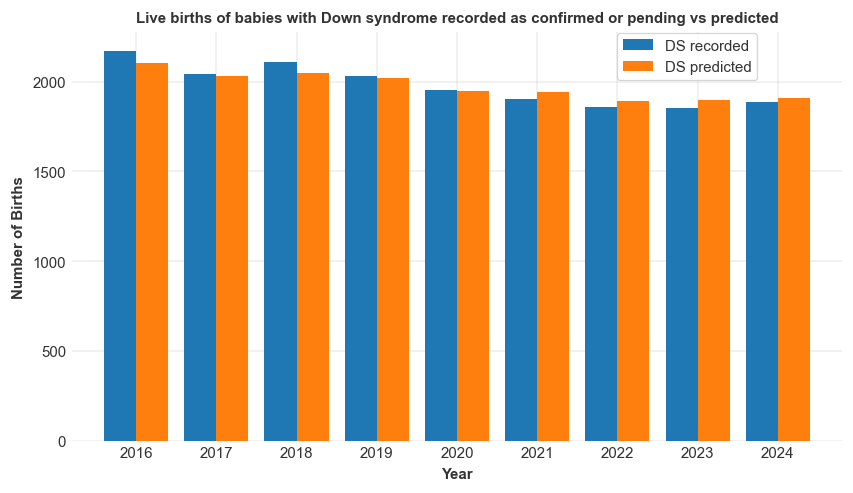

In [4]:
plt.figure(figsize=(7, 4))
# plt.fill_between(range(2003, 2015), 2250, color="#d8f0ff", alpha=0.4)
plt.bar(df["year"] - 0.2, df["down_ind"], width=0.4, label="DS recorded")
plt.bar(df["year"] + 0.2, df["down_pred"], width=0.4, label="DS predicted")
plt.xlim(2015.2, 2024.8)
plt.xticks(range(2016, 2025))
plt.xlabel("Year")
plt.ylabel("Number of Births")
plt.title(
    "Live births of babies with Down syndrome recorded as confirmed or pending vs predicted"
)
plt.legend(bbox_to_anchor=(0.9, 0.94), loc="center right")
if SAVE_PLOTS:
    plt.savefig(
        os.path.join(OUTPUT_DIR, "births_recorded_predicted.png"),
        dpi=300,
        bbox_inches="tight",
    )
    plt.savefig(
        os.path.join(OUTPUT_DIR, "births_recorded_predicted.svg"), bbox_inches="tight"
    )
plt.show()

In [5]:
df = con.execute(
    f"""
    SELECT
        b.year,
        SUM(b.down_ind) AS down_ind,
        (SELECT COUNT(*) FROM us_births WHERE year = b.year AND p_ds_lb_pred_01 >= 0.029) AS down_pred,
        SUM(b.p_ds_lb_nt * (1 - r.reduction)) AS ds_lb_est_reduc
    FROM us_births AS b
    LEFT JOIN reduction_rate_year r
        ON b.year = r.year
    WHERE b.year >= 2016
    GROUP BY b.year
    ORDER BY b.year;
    """
).df()
df

,year,down_ind,down_pred,ds_lb_est_reduc
0,2016,2168.0,4662,5128.850913
1,2017,2044.0,4539,5170.826289
2,2018,2108.0,4730,5035.392182
3,2019,2030.0,4740,5069.181474
4,2020,1954.0,4579,4915.527694
5,2021,1903.0,4339,5037.277999
6,2022,1861.0,3939,5137.556006
7,2023,1855.0,3956,5065.777423
8,2024,1886.0,3904,5137.562776


In [6]:
df = con.execute(
    f"""
    WITH year_quota AS (
        SELECT
            year,
            COUNT(*) AS n_recorded,
            CAST(CEIL(COUNT(*) * 2.5) AS BIGINT) AS n_select
        FROM us_births
        WHERE down_ind = 1
        GROUP BY year
    ),
    ranked AS (
        SELECT
            b.*,
            q.n_recorded,
            q.n_select,
            ROW_NUMBER() OVER (
                PARTITION BY b.year
                ORDER BY b.p_ds_lb_pred_01 DESC
            ) AS rn
        FROM us_births AS b
        JOIN year_quota AS q
        ON q.year = b.year
        WHERE b.p_ds_lb_pred_01 IS NOT NULL
    ),
    selected AS (
        SELECT *
        FROM ranked
        WHERE rn <= n_select
        ORDER BY year, rn
    )
    SELECT
        s.year,
        (SELECT COUNT(*) FROM us_births WHERE year = s.year AND down_ind = 1) AS down_ind_total,
        SUM(down_ind) AS down_ind_sel,
        SUM(down_ind) / (SELECT COUNT(*) FROM us_births WHERE year = s.year AND down_ind = 1) AS down_ind_ratio,
        COUNT(*) AS down_pred
    FROM selected AS s
    LEFT JOIN reduction_rate_year r
        ON s.year = r.year
    WHERE s.year >= 2016
    GROUP BY s.year
    ORDER BY s.year;
    """
).df()
df

,year,down_ind_total,down_ind_sel,down_ind_ratio,down_pred
0,2016,2168,399.0,0.184041,5420
1,2017,2044,357.0,0.174658,5110
2,2018,2108,381.0,0.180740,5270
3,2019,2030,406.0,0.200000,5075
4,2020,1954,374.0,0.191402,4885
5,2021,1903,341.0,0.179191,4758
6,2022,1861,327.0,0.175712,4653
7,2023,1855,299.0,0.161186,4638
8,2024,1886,317.0,0.168081,4715


In [7]:
df = con.execute(
    f"""
    WITH year_month_quota AS (
        SELECT
            year,
            dob_mm,
            COUNT(*) AS n_recorded,
            CAST(CEIL(COUNT(*) * 1.5) AS BIGINT) AS n_select
        FROM us_births
        WHERE down_ind = 1 AND year >= 2016
        GROUP BY year, dob_mm
    ),
    ranked AS (
        SELECT
            b.*,
            q.n_recorded,
            q.n_select,
            ROW_NUMBER() OVER (
                PARTITION BY b.year, b.dob_mm
                ORDER BY b.p_ds_lb_pred_01 DESC
            ) AS rn
        FROM us_births AS b
        JOIN year_month_quota AS q
        ON q.year = b.year AND q.dob_mm = b.dob_mm
        WHERE down_ind = 0
    ),
    missing AS (
        SELECT *
        FROM ranked
        WHERE rn <= n_select
        ORDER BY year, dob_mm, rn
    )
    SELECT
        b.mage_c,
        (SELECT COUNT(*) FROM us_births WHERE mage_c = b.mage_c AND down_ind = 1 AND year >= 2016) as ds_births_recorded,
        COUNT(m.rn) as ds_births_missing,
        (SELECT COUNT(*) FROM us_births WHERE mage_c = b.mage_c AND down_ind = 1 AND year >= 2016) + COUNT(m.rn) as ds_births_total,
        SUM(b.p_ds_lb_nt * (1 - r.reduction)) as ds_lb_est_reduc
    FROM us_births AS b
    FULL OUTER JOIN missing AS m
    ON b.id = m.id
    LEFT JOIN reduction_rate_year r
        ON b.year = r.year
    WHERE b.year >= 2016
    GROUP BY b.mage_c,
    ORDER BY b.mage_c;
    """
).df()
df

,mage_c,ds_births_recorded,ds_births_missing,ds_births_total,ds_lb_est_reduc
0,12,0,1,1,0.233316
1,13,1,2,3,1.133716
2,14,1,6,7,5.478022
3,15,16,8,24,18.249846
4,16,37,26,63,44.931320
5,17,62,51,113,89.641465
6,18,108,133,241,170.652176
7,19,208,199,407,295.999568
8,20,265,278,543,392.275836
9,21,309,332,641,463.329642


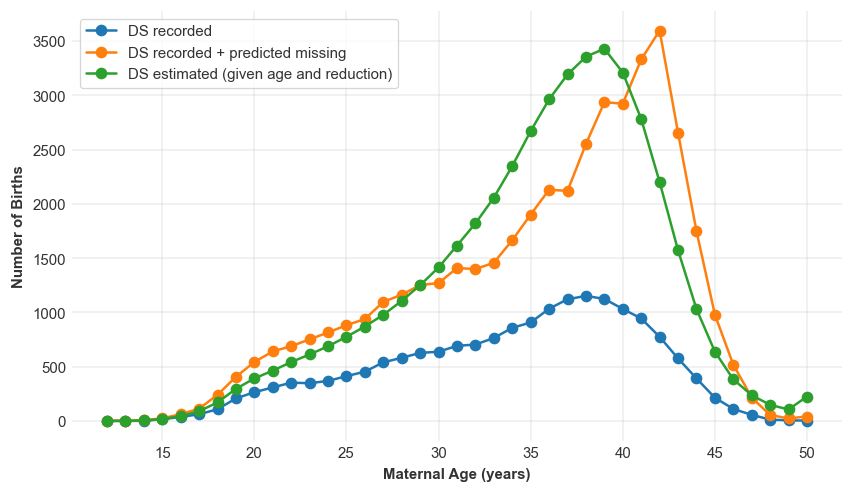

In [8]:
plt.figure(figsize=(7, 4))
plt.plot(df["mage_c"], df["ds_births_recorded"], marker="o", label="DS recorded")
plt.plot(
    df["mage_c"],
    df["ds_births_total"],
    marker="o",
    label="DS recorded + predicted missing",
)
plt.plot(
    df["mage_c"],
    df["ds_lb_est_reduc"],
    marker="o",
    label="DS estimated (given age and reduction)",
)

plt.xlabel("Maternal Age (years)")
plt.ylabel("Number of Births")
plt.legend()
plt.show()

In [9]:
df = con.execute(
    f"""
    WITH year_month_quota AS (
        SELECT
            year,
            dob_mm,
            COUNT(*) AS n_recorded,
            CAST(CEIL(COUNT(*) * 1.5) AS BIGINT) AS n_select
        FROM us_births
        WHERE down_ind = 1 AND year >= 2016
        GROUP BY year, dob_mm
    ),
    ranked AS (
        SELECT
            b.*,
            q.n_recorded,
            q.n_select,
            ROW_NUMBER() OVER (
                PARTITION BY b.year, b.dob_mm
                ORDER BY b.p_ds_lb_pred_01 DESC
            ) AS rn
        FROM us_births AS b
        JOIN year_month_quota AS q
        ON q.year = b.year AND q.dob_mm = b.dob_mm
        WHERE down_ind = 0
    ),
    missing AS (
        SELECT *
        FROM ranked
        WHERE rn <= n_select
        ORDER BY year, dob_mm, rn
    )
    SELECT
        b.mracehisp,
        (SELECT COUNT(*) FROM us_births WHERE mracehisp = b.mracehisp AND down_ind = 1 AND year >= 2016) as ds_births_recorded,
        COUNT(m.rn) as ds_births_missing,
        (SELECT COUNT(*) FROM us_births WHERE mracehisp = b.mracehisp AND down_ind = 1 AND year >= 2016) + COUNT(m.rn) as ds_births_total,
        SUM(b.p_ds_lb_nt * (1 - r.reduction)) as ds_lb_est_reduc
    FROM us_births AS b
    FULL OUTER JOIN missing AS m
    ON b.id = m.id
    LEFT JOIN reduction_rate_year r
        ON b.year = r.year
    WHERE b.year >= 2016
    GROUP BY b.mracehisp
    ORDER BY b.mracehisp;
    """
).df()
df

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,mracehisp,ds_births_recorded,ds_births_missing,ds_births_total,ds_lb_est_reduc
0,1,9419,14200,23619,23134.543163
1,2,1998,2382,4380,6084.122748
2,3,184,241,425,257.861261
3,4,628,672,1300,4006.877612
4,5,41,82,123,107.329565
5,6,383,456,839,896.539522
6,7,4969,8421,13390,10569.415035
7,8,187,288,475,641.263850


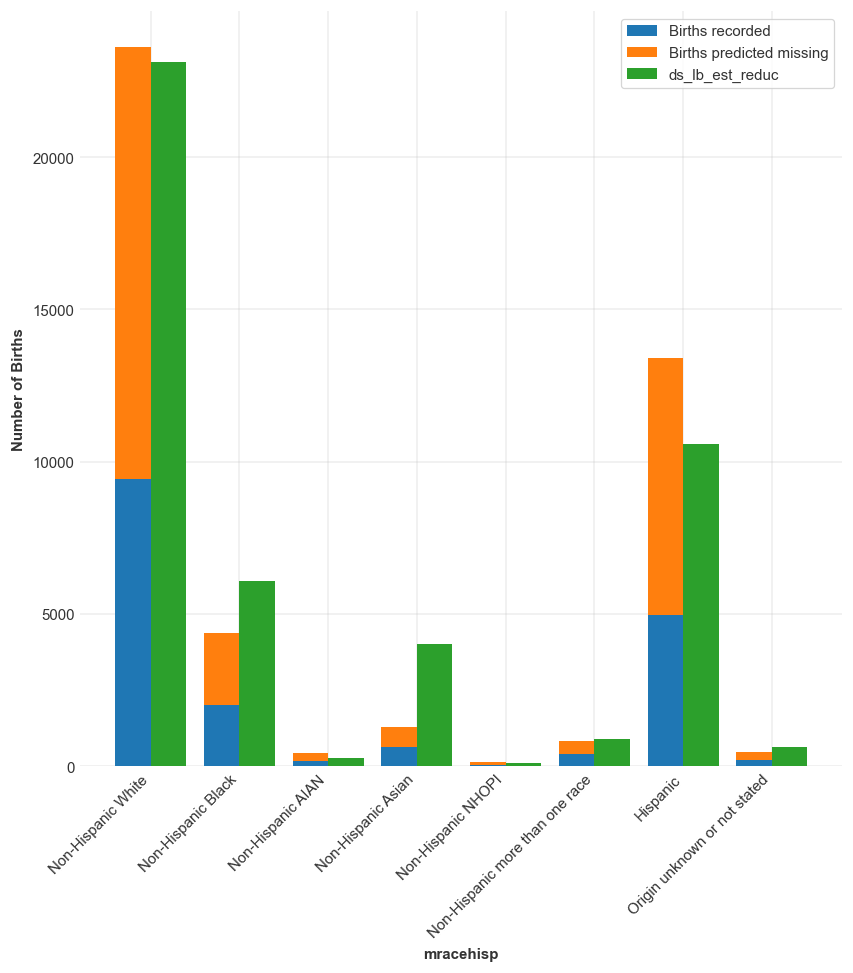

In [10]:
x_labels = {
    1: "Non-Hispanic White",
    2: "Non-Hispanic Black",
    3: "Non-Hispanic AIAN",
    4: "Non-Hispanic Asian",
    5: "Non-Hispanic NHOPI",
    6: "Non-Hispanic more than one race",
    7: "Hispanic",
    8: "Origin unknown or not stated",
}

plt.figure(figsize=(7, 8))
plt.bar(
    df["mracehisp"] - 0.2, df["ds_births_recorded"], width=0.4, label="Births recorded"
)
plt.bar(
    df["mracehisp"] - 0.2,
    df["ds_births_missing"],
    width=0.4,
    bottom=df["ds_births_recorded"],
    label="Births predicted missing",
)
plt.bar(
    df["mracehisp"] + 0.2, df["ds_lb_est_reduc"], width=0.4, label="ds_lb_est_reduc"
)
plt.xlabel("mracehisp")
plt.ylabel("Number of Births")
plt.xticks(
    df["mracehisp"],
    [x_labels.get(x, "Unknown") for x in df["mracehisp"]],
    rotation=45,
    ha="right",
)
plt.legend()
plt.show()

C:\Users\FrankBuckley\AppData\Local\Temp\ipykernel_8440\1434410740.py:32: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


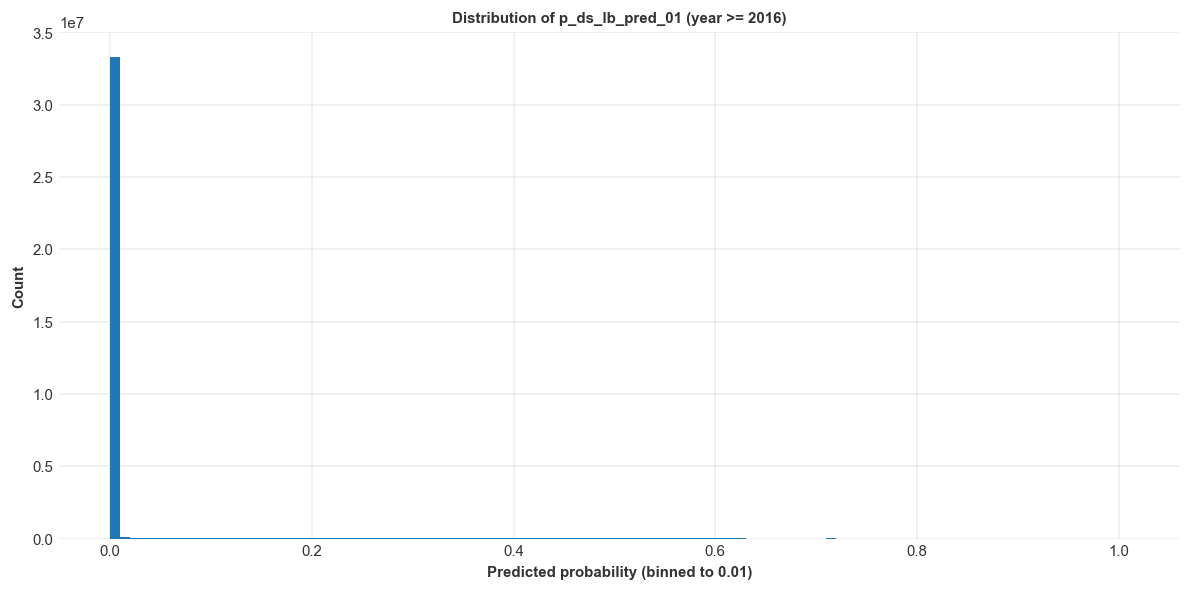

C:\Users\FrankBuckley\AppData\Local\Temp\ipykernel_8440\1434410740.py:42: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


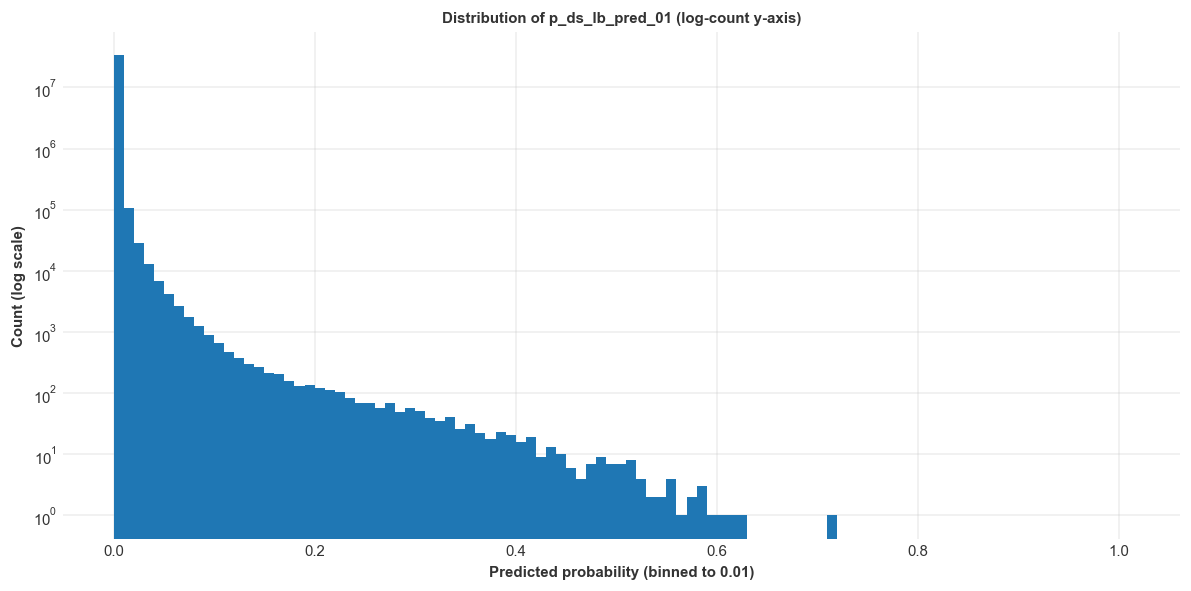

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 100 bins: [0.00, 0.01), [0.01, 0.02), ..., [0.99, 1.00]
bins_df = con.execute(
    """
    SELECT
        CAST(FLOOR(p_ds_lb_pred_01 * 100) AS INTEGER) AS bin_idx,
        COUNT(*) AS n
    FROM us_births
    WHERE year >= 2016
      AND down_ind = 0
    GROUP BY 1
    ORDER BY 1
"""
).df()

# Ensure all bins 0..100 exist (bin_idx=100 would only happen if p==1.0 exactly)
all_bins = pd.DataFrame({"bin_idx": np.arange(0, 101, dtype=int)})
bins_df = all_bins.merge(bins_df, on="bin_idx", how="left").fillna({"n": 0})
bins_df["n"] = bins_df["n"].astype(np.int64)

# Bin left-edge as the plotted x (e.g., 0.00, 0.01, ...)
bins_df["p_left"] = bins_df["bin_idx"] / 100.0

plt.figure(figsize=(10, 5))
plt.bar(bins_df["p_left"], bins_df["n"], width=0.01, align="edge")
plt.xlabel("Predicted probability (binned to 0.01)")
plt.ylabel("Count")
plt.title("Distribution of p_ds_lb_pred_01 (year >= 2016)")
plt.tight_layout()
plt.show()

# Often useful for highly skewed distributions:
plt.figure(figsize=(10, 5))
plt.bar(bins_df["p_left"], bins_df["n"], width=0.01, align="edge")
plt.yscale("log")
plt.xlabel("Predicted probability (binned to 0.01)")
plt.ylabel("Count (log scale)")
plt.title("Distribution of p_ds_lb_pred_01 (log-count y-axis)")
plt.tight_layout()
plt.show()

In [1]:
con.close()

NameError: name 'con' is not defined